In [7]:
import os

import numpy as np
import pandas as pd
from os.path import join
from tqdm import tqdm
import matplotlib.pyplot as plt
if os.getcwd().split('\\')[-1] != 'irl-chess':
    os.chdir('../')
from project import download_lichess_pgn, get_midgame_boards


In [8]:
n_files = np.inf
websites_filepath = join(os.getcwd(), 'downloads', 'lichess_websites.txt')
file_path_data = join(os.getcwd(), 'data', 'raw')

datapaths = download_lichess_pgn(websites_filepath, file_path_data, n_files=n_files, overwrite=False)



-------------------  1/12  -------------------


c:\Users\gabri\OneDrive - Danmarks Tekniske Universitet\Lokale Filer\DTU\Forår 2024\Bachelor\irl-chess\data\processed\lichess_db_standard_rated_2013-01.csv already exists and was not changed
Time taken: 0.01 seconds for file
Time taken: 0.01 seconds in total


-------------------  2/12  -------------------


c:\Users\gabri\OneDrive - Danmarks Tekniske Universitet\Lokale Filer\DTU\Forår 2024\Bachelor\irl-chess\data\processed\lichess_db_standard_rated_2013-02.csv already exists and was not changed
Time taken: 0.00 seconds for file
Time taken: 0.01 seconds in total


-------------------  3/12  -------------------


c:\Users\gabri\OneDrive - Danmarks Tekniske Universitet\Lokale Filer\DTU\Forår 2024\Bachelor\irl-chess\data\processed\lichess_db_standard_rated_2013-03.csv already exists and was not changed
Time taken: 0.00 seconds for file
Time taken: 0.01 seconds in total


-------------------  4/12  -------------------


c:\Users\gabri\OneD

In [9]:
df = pd.read_csv(datapaths[0], index_col=None)

for path in tqdm(datapaths[1:2]):
    df_ = pd.read_csv(path, index_col=None)
    df = pd.concat((df, df_), axis=0)
df.dropna(inplace=True)

100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


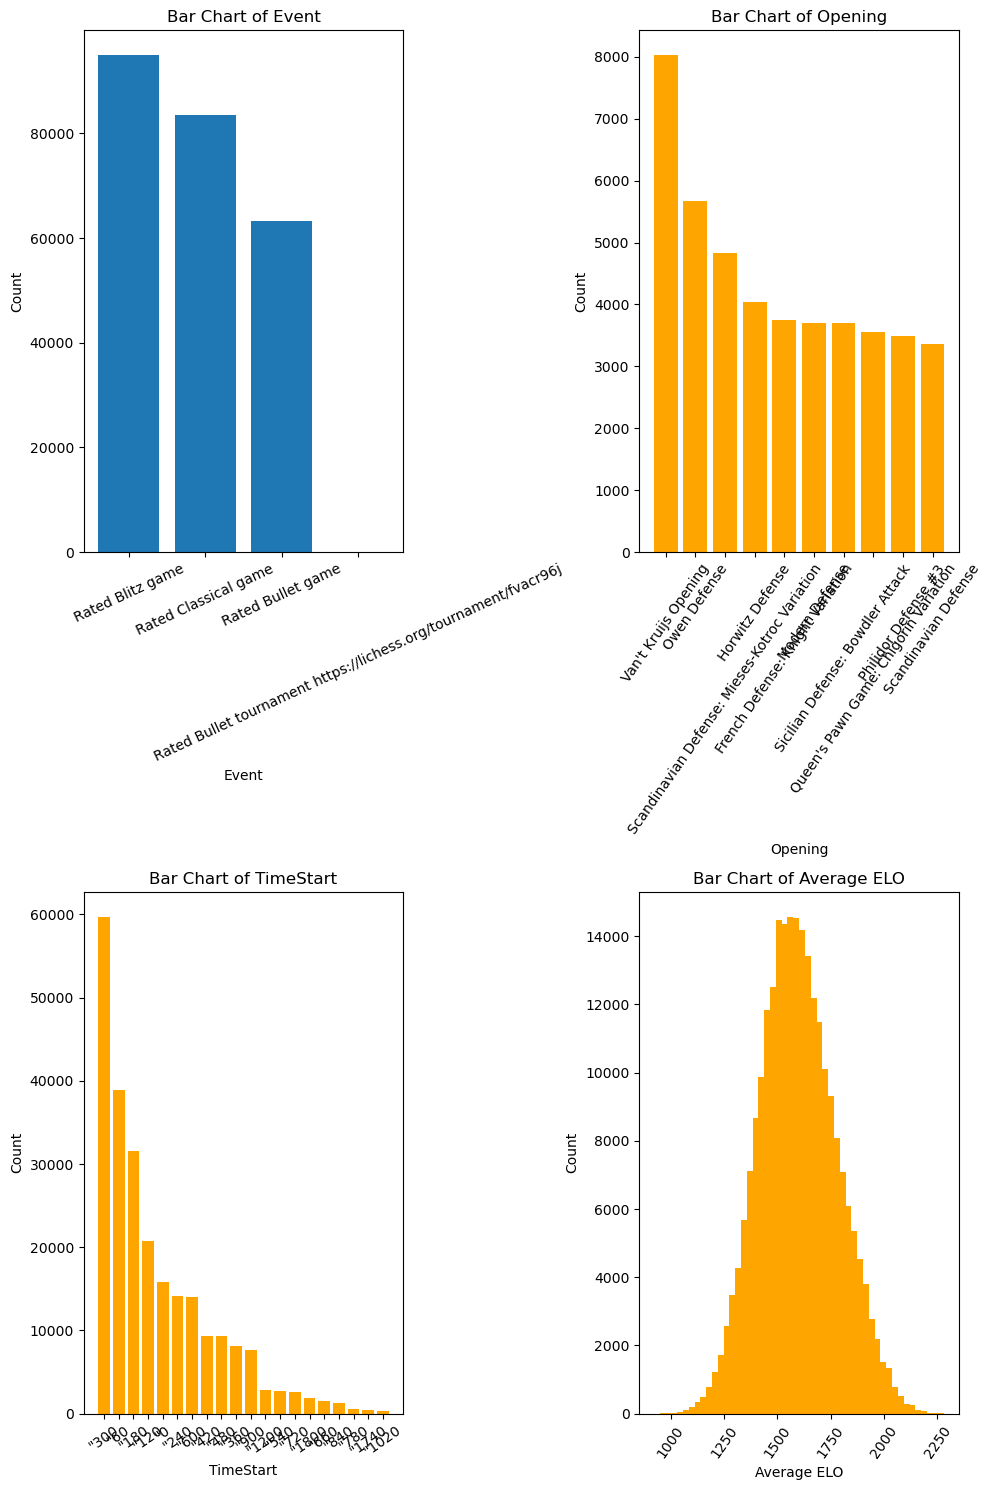

In [10]:
n_event = 4
n_time = 20
n_opening = 10
fig, axes = plt.subplots(2, 2, figsize=(10, 15))

plot_val = 'Event' 
class_counts_event = df[plot_val].value_counts()[:n_event]
axes[0, 0].bar(class_counts_event.index[:n_event], class_counts_event.values)
axes[0, 0].set_xlabel(plot_val)
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Bar Chart of ' + plot_val)
axes[0, 0].tick_params(axis='x', rotation=25)  # Rotate x-axis labels

plot_val = 'TimeStart'
class_counts_time_control = df[plot_val].value_counts()[:n_time]
axes[1, 0].bar(class_counts_time_control.index[:n_time], class_counts_time_control.values, color='orange')
axes[1, 0].set_xlabel(plot_val)
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title(f'Bar Chart of {plot_val}')
axes[1, 0].tick_params(axis='x', rotation=35)  # Rotate x-axis labels

plot_val = 'Opening'
class_counts_opening = df[plot_val].value_counts()[:n_opening]
axes[0, 1].bar(class_counts_opening.index[:n_opening], class_counts_opening.values, color='orange')
axes[0, 1].set_xlabel(plot_val)
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Bar Chart of ' + plot_val)
axes[0, 1].tick_params(axis='x', rotation=55)  # Rotate x-axis labels

plot_val = 'Average ELO'
mask_valid_elo = df[['WhiteElo']].values == '?'
mask_ = df[['BlackElo']].values == '?'
mask_valid_elo = np.logical_not((mask_valid_elo + mask_).flatten())
axes[1, 1].hist(df[['WhiteElo', 'BlackElo']].values[mask_valid_elo].astype(int).mean(axis=1), bins=50, color= 'orange')
axes[1, 1].set_xlabel(plot_val)
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Bar Chart of ' + plot_val)
axes[1, 1].tick_params(axis='x', rotation=55)  # Rotate x-axis labels

# Adjust layout
plt.tight_layout()
plt.show()

Chess time control notation states the number of seconds players start with + the increment per move
so 60 + 0 means each player only has 60 seconds for the entire game and
300 + 8 means 6 minutes to start and 8 seconds per move made. 

In [11]:
df.columns

Index(['Event', 'Site', 'White', 'Black', 'Result', 'UTCDate', 'UTCTime',
       'WhiteElo', 'BlackElo', 'WhiteRatingDiff', 'BlackRatingDiff', 'ECO',
       'Opening', 'TimeStart', 'TimeIncrement', 'Termination', 'Moves'],
      dtype='object')

In [19]:
from project import get_best_move, piece 
from time import time
from copy import copy
from scipy.special import softmax


def softmax_choice(x):
    """
    Returns an index based on the softmax of x and add 1 to ensure 
    the depth is never 0
    :param x: 
    :return: 
    """
    choice = np.random.choice(np.arange(len(x)), p=softmax(x))
    return choice + 1

def prob_dist(R, energy, alpha, prior=lambda R: 1):
    prob = np.exp(alpha * energy) * prior(R)
    return prob

def log_prob_dist(R, energy, alpha, prior=lambda R: 1):
    log_prob = alpha * energy + np.log(prior(R))
    return log_prob

def policy_walk_depth(R, boards, moves, delta=1e-3, epochs=10, depth_max=3, alpha=2e-2, time_max=np.inf, timer_moves=False):
    depth_dist = np.ones(depth_max)
    start = time()
    for epoch in tqdm(range(epochs)):
        add = np.random.uniform(low=-delta, high=delta, size=depth_dist.shape[0]).astype(depth_dist.dtype) # * (delta / 2)
        depth_dist_ = depth_dist + add
        Q_moves = np.zeros(len(boards))
        Q_policy = np.zeros(len(boards))
        i = 0
        energy_new, energy_old = 0, 0
        for board, move in tqdm(zip(boards, moves), total=len(boards)):
            board.push_san(move)
            depth1 = softmax_choice(depth_dist)
            depth2 = softmax_choice(depth_dist_)
            _, Q_old = get_best_move(board=board, R=R, depth=depth1, timer=timer_moves, white=board.turn)
            _, Q_new = get_best_move(board=board, R=R, depth=depth2, timer=timer_moves, white=board.turn)
            if Q_new is None or Q_old is None:
                continue
            board.pop()
            
            Q_moves[i] = Q_old
            Q_policy[i] = Q_new
            
            energy_old += Q_old
            energy_new += Q_new

            i += 1
            # prob = min(1, prob_dist(depth_dist_, energy_new, alpha=alpha)/prob_dist(depth_dist, energy_old, alpha=alpha))

            log_prob = min(0, log_prob_dist(depth_dist_, energy_new, alpha=alpha) - log_prob_dist(depth_dist, energy_old, alpha=alpha))
            
            if np.sum(Q_policy < Q_moves):
                if log_prob > -1e7 and np.random.rand(1).item() < np.exp(log_prob): 
                    depth_dist = copy(depth_dist_)
            if start - time() > time_max:
                return depth_dist
    return depth_dist

In [28]:
from project import piece
boards, moves = get_midgame_boards(df, n_boards=100, min_elo=1200, max_elo=1400)

R = np.array([val for val in piece.values()])

depth_result = policy_walk_depth(R, boards, moves, depth_max=5, time_max=100, epochs=1, timer_moves=False, delta=0.1)

  0%|          | 0/1 [04:53<?, ?it/s]


KeyboardInterrupt: 

In [27]:
depth_result

array([0.94964393, 1.09130151, 1.01800694])

In [ ]:
softmax_choice(np.random.rand(4))

2